In [2]:
import torch
from transformers import BertForSequenceClassification
from dotenv import load_dotenv

from degree_inference.cah_data import CAHData
from degree_inference.predict import predict
from degree_inference.train import train

load_dotenv() 

from google.cloud import bigquery

%load_ext google.cloud.bigquery

In [95]:
c = CAHData(include_ilr=True, include_gpt_inferences=False, augment=False)

Text(0, 0.5, 'CAH3 codes with this many examples')

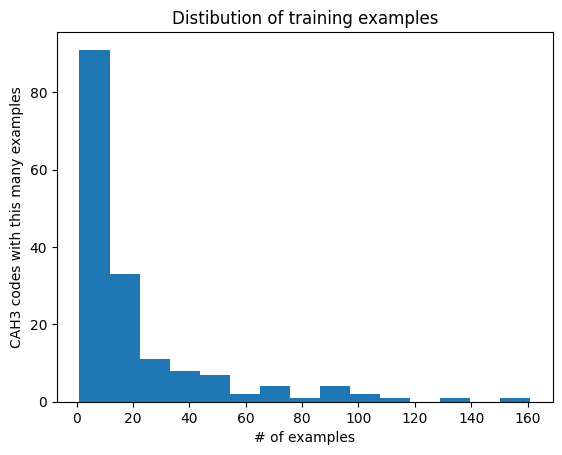

In [105]:
import matplotlib.pyplot as plt
import numpy as np

counts = c.df['label'].value_counts()
plt.hist(counts, bins=15)
plt.title("Distibution of training examples")
plt.xlabel("# of examples")
plt.ylabel("CAH3 codes with this many examples")
# counts, bins = np.histogram(counts)
# plt.stairs(counts, bins)
# counts.plot(kind='bar').set(xlabel=None)
# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# plt.title("Frequency of CAH3 codes")

In [19]:
%%bigquery degree_name_to_hecos
SELECT
  LOWER(cq.subject) AS text,
  cq.degree_subject_cah_l3 as label
FROM
  `rugged-abacus-218110.dataform_ABS_2_dev.application_choice_details`
LEFT JOIN
  UNNEST(candidate_qualifications) AS cq
LEFT JOIN `rugged-abacus-218110.dfe_reference_data.cah_categories_l3_v2` AS cah_codes ON cah_codes.id = degree_subject_cah_l3
WHERE degree_level IS NOT NULL AND degree_level !='unknown'
AND degree_subject_cah_l3 IS NOT NULL
GROUP BY 
text,
label

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
data = CAHData(include_ilr=False, augment=False, include_gpt_inferences=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data.df['label'].unique()))
mps_device = torch.device("mps")
model.to(mps_device)

trainer = train(model,data,epochs=30,comment="cah")

model.save_pretrained("./models/cah")

data = CAHData(include_ilr=True, augment=False, include_gpt_inferences=False)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data.df['label'].unique()))
mps_device = torch.device("mps")
model.to(mps_device)

trainer = train(model,data,epochs=16,comment="cah-ilr")
model.save_pretrained("./models/cah-ilr")
# model.to("cpu")

data = CAHData(include_ilr=True, augment=False, include_gpt_inferences=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data.df['label'].unique()))
mps_device = torch.device("mps")
model.to(mps_device)

trainer = train(model,data,epochs=12,comment="cah-ilr-gpt")

model.save_pretrained("./models/cah-ilr-gpt")

data = CAHData(include_ilr=True, augment=True, include_gpt_inferences=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data.df['label'].unique()))
mps_device = torch.device("mps")
model.to(mps_device)

trainer = train(model,data,epochs=12,comment="cah-ilr-gpt-augmented")

model.save_pretrained("./models/cah-ilr-gpt-augmented")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/duncan/projects/transformers/.venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
200,4.607100,4.542198
400,4.039500,4.029944
600,3.745000,3.665502
800,3.318200,3.339688
1000,2.974400,3.068465
1200,2.810100,2.832941
1400,2.470200,2.639329
1600,2.305900,2.489846
1800,2.035000,2.357273
2000,2.070600,2.241990


None


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/duncan/projects/transformers/.venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
200,4.535900,4.453227
400,4.232400,4.072093
600,3.816100,3.629062
800,3.398900,3.244115
1000,3.107700,2.989307
1200,2.656000,2.734499
1400,2.827100,2.533079
1600,2.444000,2.395833
1800,2.310500,2.252913
2000,1.991300,2.131483


None


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/duncan/projects/transformers/.venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
200,4.568500,4.515294
400,4.369300,4.073011
600,3.779200,3.678241
800,3.441500,3.298954
1000,3.201200,2.972135
1200,2.971400,2.729782
1400,2.461900,2.517050
1600,2.432300,2.358477
1800,2.364200,2.238315
2000,2.143000,2.099734


KeyboardInterrupt: 

In [10]:
out = predict(data, model,list(degree_name_to_hecos['text']))
out

In [11]:
model.save_pretrained("./models/cah-ilr-gpt-augmented")

In [7]:
model.save_pretrained("./cah-ilr-gpt-augmented")

In [11]:
data.df['label'].unique()


array(['03-02-01', '03-01-10', '15-04-03', '10-01-03', '15-01-02',
       '17-01-09', '15-01-03', '19-04-01', '20-02-02', '07-04-04',
       '15-04-01', '19-01-02', '19-02-04', '25-01-03', '25-01-04',
       '09-01-01', '22-01-02', '02-05-02', '15-02-01', '10-01-07',
       '10-01-08', '15-03-01', '24-01-05', ' 20-01-01', '11-01-02',
       '11-01-06', '17-01-07', '23-01-01', ' 22-01-01', ' 01-01-01',
       '19-01-03', '19-04-09', '26-01-01', '22-01-01', '25-02-03',
       '17-01-08', '11-01-05', '25-01-02', '20-01-01', '17-01-04',
       ' 15-04-01', '26-01-04', '17-01-01', '03-01-03', '03-01-06',
       ' 25-01-04', '25-02-04', '25-02-02', '06-01-04', '19-04-05',
       '11-01-04', '25-02-01', '07-01-01', '24-01-04', '01-01-02',
       '02-02-01', '19-04-08', '19-01-05', '04-01-01', '16-01-01',
       '25-01-01', '04-01-04', '20-01-03', '17-01-02', '19-04-04',
       '25-01-05', '03-01-08', '11-01-01', '07-02-01', '04-01-02',
       '26-01-03', '26-01-06', '10-01-09', ' 26-01-03', '

In [16]:
%%bigquery unlabelled
SELECT
        cq.subject AS degree_subject,
        cq.degree_subject_cah_l3,
        cah_codes.name AS cah_category_name
    FROM
        `rugged-abacus-218110.dataform_ABS_2_dev.application_choice_details`
    LEFT JOIN
        UNNEST(candidate_qualifications) AS cq
    LEFT JOIN `rugged-abacus-218110.dfe_reference_data.cah_categories_l3_v2` AS cah_codes ON cah_codes.id = degree_subject_cah_l3
    WHERE degree_level IS NOT NULL AND degree_level !='unknown'
    AND nationality_group = "British"
    AND degree_subject_cah_l3 IS NULL
    GROUP BY
        degree_subject,
        degree_subject_cah_l3,
        cah_category_name
    ORDER BY RAND()
    LIMIT 100


Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
# Inference

# load pretrained model
model = BertForSequenceClassification.from_pretrained('./30-epoch-gpt2-ilr-augmented-1e-5/', num_labels=len(data.df['label'].unique()))
model.to("cpu")

out = predict(data, model,list(unlabelled.degree_subject))
for row in out:
    print(row)

('Single Honours Psychology', '04-01-02', 'applied psychology')
('BA Urban Regeneration and Planning', '13-01-04', 'planning (urban, rural and regional)')
('Molecular science', '03-01-08', 'molecular biology, biophysics and biochemistry')
('History and geography', '26-01-01', 'geography (non-specific)')
('Mathematical Sciences (Environmental Sciences)', '09-01-01', 'mathematics')
('Economics & Statistics', '09-01-03', 'statistics')
('Criminology and Criminal Justice ', '15-04-01', 'social work')
('History (HL)', '20-01-01', 'history')
('Irish History and Politics', '19-04-08', 'American and Australasian studies')
('business management (legal regulations)', '17-01-01', 'business and management (non-specific)')
('English & History', '19-01-01', 'English studies (non-specific)')
('BA Turkish and History', '19-04-07', 'African and modern Middle Eastern studies')
('Broadcast Journalism', '24-01-04', 'journalism')
('Music and Hispanic Studies', '25-02-02', 'music')
('Bsc (Hons) Television Te